In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
trainsets = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)

testsets = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

In [3]:
class_names = trainsets.classes  # 查看类别、标签
print(class_names)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [4]:
# 查看数据集的大小
print(trainsets.targets.shape)

torch.Size([60000])


In [5]:
print(testsets.targets.shape)

torch.Size([10000])


In [6]:
# 定义超参数
BATCH_SIZE = 128
EPOCHS = 10

In [7]:
# 创建数据集的可迭代对象，一个BATCH一个BATCH的读取
train_loader = torch.utils.data.DataLoader(trainsets, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(testsets, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
# 查看一批BATCH的数据

iamges, labels = next(iter(train_loader))

In [9]:
print(iamges.shape)

torch.Size([128, 1, 28, 28])


In [10]:
print(labels.shape)

torch.Size([128])


In [11]:
# 定义函数，显示一批数据
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))  # 见上文1,28,28，格式要求把28,28放到前面，把颜色通道1放到后面。
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225]) # 标准差
    inp = std * inp + mean  # 从numpy到tensor有一个归一化的过程，这个过程相当于反归一化
    inp = np.clip(inp, 0, 1) # 将数据进行压缩，像素值限制在0到1
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [12]:
# 通过网格显示
out = torchvision.utils.make_grid(iamges)
imshow(out)

In [13]:
# 定义RNN模型
class RNN_Model(nn.Module):
    def __init__(self, input_size, hidden_size, layer_size, output_size):
        super(RNN_Model, self).__init__()
        self.hidden_size = hidden_size
        self.layer_size = layer_size
        self.rnn = nn.RNN(input_size, hidden_size, layer_size, batch_first=True, nonlinearity='relu')
        
        # 全连接层
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.layer_size, x.size(0), self.hidden_size).requires_grad_().to(device)
        # 分离隐藏层状态，防止梯度爆炸
        out, hn = self.rnn(x, h0.detach())
        out = self.fc(out[:, -1, :])
        return out

In [14]:
# 初始化模型
input_size = 28
hidden_size = 128
layer_size = 2
output_size = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RNN_Model(input_size, hidden_size, layer_size, output_size).to(device)



In [15]:
# 定义损失函数
criterion = nn.CrossEntropyLoss()  # 交叉熵


In [16]:
# 定义优化器
optimizer = torch.optim.SGD(model.parameters(), lr=0.012)

In [17]:
# 11.输出模型信息
print(len(list(model.parameters())))


10


In [18]:
# 循环打印模型参数
for i in range(10):
    print("参数：%d"% (i + 1))
    print(list(model.parameters())[i].size())
    

参数：1
torch.Size([128, 28])
参数：2
torch.Size([128, 128])
参数：3
torch.Size([128])
参数：4
torch.Size([128])
参数：5
torch.Size([128, 128])
参数：6
torch.Size([128, 128])
参数：7
torch.Size([128])
参数：8
torch.Size([128])
参数：9
torch.Size([10, 128])
参数：10
torch.Size([10])


In [19]:
# 进行模型训练
sequence_size = 28
loss_list = []
accuracy_list = []
iteration_list = []  # 保存循环次数

iter = 0
for epoch in range(EPOCHS):
    for i, (images, labels) in enumerate(train_loader):  # 拿一批数据
        model.train()
        images = images.view(-1, sequence_size, input_size).requires_grad_().to(device)
        labels = labels.to(device)
        # 梯度清零
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step() # 更新参数
        iter += 1
        if iter % 500 == 0:
            model.eval()
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.view(-1, sequence_size, input_size).to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                if torch.cuda.is_available():
                    correct += (predicted.cuda() == labels.cuda()).sum()
                else:
                    correct += (predicted == labels).sum
                    
            accuracy = correct / total * 100
            loss_list.append(loss.data)
            accuracy_list.append(accuracy)
            iteration_list.append(iter)
            
            print("loop:{}, loss:{}, accuracy:{}".format(iter, loss.item(), accuracy))

loop:500, loss:2.2949116230010986, accuracy:11.350000381469727
loop:1000, loss:2.2779314517974854, accuracy:13.00999927520752
loop:1500, loss:2.2339136600494385, accuracy:19.190000534057617
loop:2000, loss:1.0955324172973633, accuracy:57.41999816894531
loop:2500, loss:0.7121160626411438, accuracy:66.99999237060547
loop:3000, loss:0.5171836614608765, accuracy:83.83000183105469
loop:3500, loss:0.46500808000564575, accuracy:88.1199951171875
loop:4000, loss:0.26746976375579834, accuracy:91.47999572753906
loop:4500, loss:0.1759953498840332, accuracy:94.07999420166016


In [20]:
iteration_list=torch.tensor(iteration_list, device='cpu')
loss_list=torch.tensor(loss_list, device='cpu')
accuracy_list=torch.tensor(accuracy_list, device='cpu')

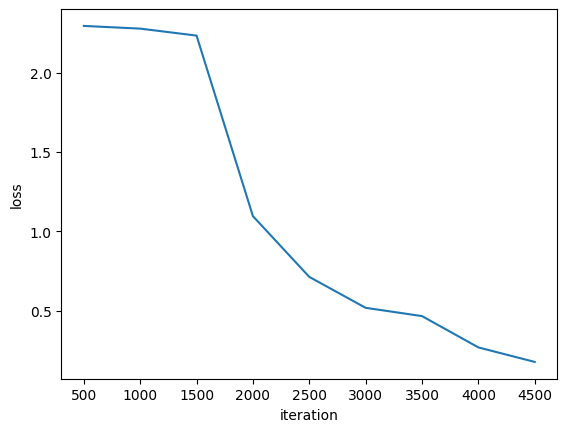

In [21]:
# 可视化
plt.plot(iteration_list, loss_list, label='loss')
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

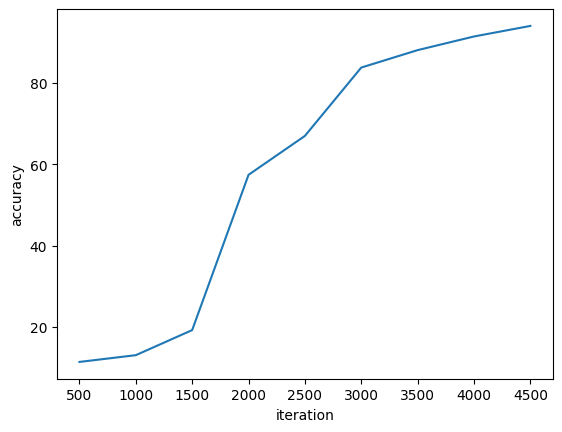

In [22]:
plt.plot(iteration_list, accuracy_list, label='accuracy')
plt.xlabel("iteration")
plt.ylabel("accuracy")
plt.show()